In [2]:
import pandas as pd
import numpy as np
import datetime
import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer


pd.set_option('Display.max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

### ★ Disagreement Data from Cookson and Neissner (2020) JF

In [3]:
raw = pd.read_stata("./CooksonNiessner2020_Disagree.dta")
raw.head(3)
raw.shape

(2651379, 5)

In [4]:
np.mean(raw['dis_all']), np.mean(raw['dis_within_group']), np.mean(raw['dis_across_group'])

(0.25305012, 0.014839471, 0.011729893)

In [5]:
permno_seq = raw['permno'].unique()
permno_seq.shape

(6056,)

In [6]:
index_raw = raw['permno'].value_counts()
index = index_raw.index[0:100].to_series().reset_index(drop=True)
index.tail()

95   90049.00000
96   86444.00000
97   82567.00000
98   11891.00000
99   60628.00000
dtype: float64

In [7]:
raw_top = raw.loc[raw['permno'].isin(index)]
raw_top.sort_values('date')

,permno,date,dis_all,dis_within_group,dis_across_group
60535,86868.00000,2010-01-01,0.00000,0.00000,0.00000
10839,84788.00000,2010-01-01,0.00000,0.00000,0.00000
15777,14593.00000,2010-01-01,0.00000,0.00000,0.00000
27043,38703.00000,2010-01-01,0.00000,0.00000,0.00000
34015,90448.00000,2010-01-01,0.00000,0.00000,0.00000
...,...,...,...,...,...
2339455,78877.00000,2018-12-31,0.75993,0.28289,0.44745
2550486,14593.00000,2018-12-31,0.99175,0.91858,0.39661
2583895,77274.00000,2018-12-31,0.94281,0.00000,0.00000
2499753,85914.00000,2018-12-31,0.00000,0.00000,0.00000


In [8]:
raw_top.groupby('date').mean()

,permno,dis_all,dis_within_group,dis_across_group
date,,,,
2010-01-01,66633.00000,0.00000,0.00000,0.00000
2010-01-02,66605.08333,0.08333,0.00000,0.00000
2010-01-03,65914.43750,0.29103,0.00000,0.00000
2010-01-04,67574.05882,0.40769,0.00000,0.00000
2010-01-05,68289.08621,0.49477,0.01026,0.00515
...,...,...,...,...
2018-12-27,64601.47674,0.72629,0.09107,0.06358
2018-12-28,63695.87640,0.70547,0.10328,0.04946
2018-12-29,64604.68966,0.39528,0.02747,0.02793


In [9]:
raw_group = raw_top.groupby('date').mean()
dis = raw_group['dis_all']
dis.name = 'dis'
dis

date
2010-01-01   0.00000
2010-01-02   0.08333
2010-01-03   0.29103
2010-01-04   0.40769
2010-01-05   0.49477
               ...  
2018-12-27   0.72629
2018-12-28   0.70547
2018-12-29   0.39528
2018-12-30   0.38501
2018-12-31   0.52012
Name: dis, Length: 3287, dtype: float32

In [10]:
np.mean(dis)

0.53153527

### ★ Twitter Sentiment Index

In [96]:
# twitter = pd.read_csv("./sent_score.csv")
# twitter.head()

In [97]:
twitter = pd.read_csv("./sent_score.csv")
twitter['Date'] = twitter['Date'].shift(1)
twitter = twitter.dropna()
twitter['Date'] = pd.to_datetime(twitter['Date'].astype("string")).dt.to_period('d')
twitter = twitter.set_index('Date').to_timestamp()
twitter.head()

,Score
Date,
2010-01-01,0.23462
2010-01-02,0.26096
2010-01-03,0.27833
2010-01-04,0.06372
2010-01-05,0.09855


### ★ Google Trend Data

In [53]:
google_df = pd.read_csv("./google_trend.csv")
google_df['date'] = pd.to_datetime(google_df['date'].astype("string")).dt.to_period('d')
google_df = google_df.set_index('date').to_timestamp()
google_df.columns = ['google_1', 'google_2', 'google_3', 'google_4', 'google_5', 'google_6']
google_df.head()

,google_1,google_2,google_3,google_4,google_5,google_6
date,,,,,,
2010-01-01,2.00000,0.00000,6.00000,4.00000,0.00000,6.00000
2010-01-02,2.00000,0.00000,0.00000,4.00000,42.00000,1.00000
2010-01-03,2.00000,0.00000,5.00000,3.00000,24.00000,0.00000
2010-01-04,4.00000,46.00000,7.00000,6.00000,39.00000,7.00000
2010-01-05,4.00000,0.00000,7.00000,7.00000,28.00000,7.00000


### ★ News Sentiment Index

### ★ VIX, SPY, OIL, DJI, MSCI

In [20]:
from datetime import datetime

st_year, st_month, st_date = 2010, 1, 1
ed_year, ed_month, ed_date = 2018, 12, 31

date_range = pd.date_range(datetime(st_year, st_month, st_date), datetime(ed_year, ed_month, ed_date))
date_range.shape

(3287,)

In [21]:
import pandas_datareader as web

tickers = ["^GSPC", "CL=F","^DJI","MSCI"]
vix_ticker = ['^VIX']
multpl_stocks = web.get_data_yahoo(tickers, start = "2010-01-01", end = "2018-12-31")
vix = web.get_data_yahoo(vix_ticker, start = "2010-01-01", end = "2018-12-31")

In [22]:
df_stock = np.log(multpl_stocks['Adj Close']).pct_change().dropna()
df_vix = np.log(vix['Adj Close'])

In [23]:
df_adj = pd.concat([df_vix, df_stock], axis = 1).dropna()
df_adj.head()

Symbols,^VIX,^GSPC,CL=F,^DJI,MSCI
Date,,,,,
2010-01-04,2.99773,0.00227,0.00611,0.00160,0.00168
2010-01-05,2.96269,0.00044,0.00072,-0.00012,0.00111
2010-01-06,2.95282,0.00008,0.00388,0.00002,-0.00813
2010-01-07,2.94759,0.00057,-0.00142,0.00034,0.01987
2010-01-08,2.89757,0.00041,0.00025,0.00012,0.00966


### ★ Other economic variables

In [24]:
import fredapi as fa

fred = fa.Fred(api_key='d3babc35e4542344ce5814bc206fddaa')

In [25]:
"""  Crude Oil Prices: West Texas Intermediate (WTI) """
oil = fred.get_series('DCOILWTICO', observation_start = "1/1/2010", observation_end = "12/31/2018")
oil.name = 'oil'
oil.tail(3)

2018-12-27   44.48000
2018-12-28   45.15000
2018-12-31        NaN
Name: oil, dtype: float64

In [26]:
""" Dollar Index DXY """
dxy = fred.get_series('DTWEXBGS', observation_start = "1/1/2010", observation_end = "12/31/2018")
dxy.name = 'DXY'
dxy.tail(3)

2018-12-27   115.99480
2018-12-28   115.72530
2018-12-31   115.56950
Name: DXY, dtype: float64

In [27]:
""" Credit Spread """
credit = fred.get_series("BAMLH0A0HYM2", observation_start = "1/1/2010", observation_end = "12/31/2018")
credit.name = 'credit'
credit.tail()

2018-12-25       NaN
2018-12-26   5.37000
2018-12-27   5.38000
2018-12-28   5.30000
2018-12-31   5.33000
Name: credit, dtype: float64

In [28]:
""" 10 YR Treasury  """
term = fred.get_series("T10Y3M", observation_start = "1/1/2010", observation_end = "12/31/2018")
term.name = 'term'
term.head()

2010-01-01       NaN
2010-01-04   3.77000
2010-01-05   3.70000
2010-01-06   3.79000
2010-01-07   3.80000
Name: term, dtype: float64

<AxesSubplot:xlabel='date'>

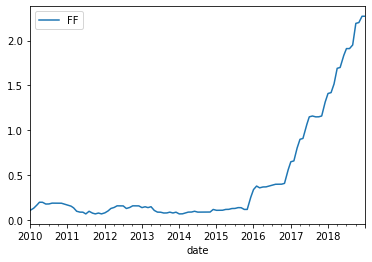

In [29]:
""" FFDeviation  """
FF = pd.DataFrame(fred.get_series("FEDFUNDS", observation_start = "1/1/2010", observation_end = "12/31/2018"))
FF['date'] = FF.index
df_FF = pd.DataFrame(FF).reset_index(drop = True)
df_FF['date'] = pd.to_datetime(df_FF['date']).dt.to_period('m')
df_FF = df_FF.set_index('date').resample('D').interpolate(method='linear').to_timestamp()
df_FF.columns = ['FF']
df_FF.plot()

In [30]:
""" 1 Year T Bill Rate """

tbill = fred.get_series("DTB1YR", observation_start = "1/1/2010", observation_end = "12/31/2018")
tbill.name = 'tbill'
tbill.head()

2010-01-01       NaN
2010-01-04   0.41000
2010-01-05   0.37000
2010-01-06   0.36000
2010-01-07   0.36000
Name: tbill, dtype: float64

In [31]:
""" Fama-French EMR, SMB, HML, Short-term Reversal """

emr_raw = pd.read_csv("./data/F-F_Research_Data_5_Factors_2x3_daily.csv").dropna()
str_raw = pd.read_csv("./data/F-F_ST_Reversal_Factor_daily.csv").dropna()

# datetime.strptime(emr_raw['date'].astype("string"), '%Y%m%d')

emr_raw['date'] = pd.to_datetime(emr_raw['date'].astype("string")).dt.to_period('d') #strftime('%Y-%m-%d')
str_raw['date'] = pd.to_datetime(str_raw['date'].astype("string")).dt.to_period('d')

emr_raw = emr_raw.loc[:,['date','Mkt-RF','SMB','HML','RF']].set_index('date').to_timestamp()
str_raw = str_raw.set_index('date').to_timestamp()


In [32]:
""" Spot Exchange rate EUR & CNY & GBP & JPY : Log return """

eur_raw = fred.get_series("DEXUSEU", observation_start = "1/1/2010", observation_end = "12/31/2018")
eur = np.log(eur_raw).pct_change().dropna()
eur.name = 'eur'

cny_raw = fred.get_series("DEXCHUS", observation_start = "1/1/2010", observation_end = "12/31/2018")
cny = np.log(cny_raw).pct_change().dropna()
cny.name = 'cny'

gbp_raw = fred.get_series("DEXUSUK", observation_start = "1/1/2010", observation_end = "12/31/2018")
gbp = np.log(gbp_raw).pct_change().dropna()
gbp.name = 'gbp'

jpy_raw = fred.get_series("DEXJPUS", observation_start = "1/1/2010", observation_end = "12/31/2018")
jpy = np.log(jpy_raw).pct_change().dropna()
jpy.name = 'jpy'


currency = pd.concat([eur, cny, gbp, jpy], axis=1)

In [33]:
""" Turnover Ratio : daily volume divided by total market capitalization """

cap = fred.get_series("WILL5000PRFC", observation_start = "1/1/2010", observation_end = "12/31/2018")
cap.name = 'cap'

vol = multpl_stocks['Volume'].loc[:,['^GSPC', "^DJI", "MSCI"]]

df_tr = pd.concat([vol, cap], axis = 1).dropna()
df_tr['GSPC_TR'] = df_tr['^GSPC']/(cap*100000)
df_tr['DJI_TR'] = df_tr['^DJI']/(cap*10000)
df_tr['MSCI_TR'] = df_tr['MSCI']/(cap*100)

df_tr_temp = df_tr.loc[:, ['GSPC_TR', 'DJI_TR','MSCI_TR']]
df_tr_temp["GSPC_TR_Change"] = np.log(df_tr_temp['GSPC_TR']).pct_change().dropna()
df_tr_temp["DJI_TR_Change"] = np.log(df_tr_temp['DJI_TR']).pct_change().dropna()
df_tr_temp["MSCI_TR_Change"] = np.log(df_tr_temp['MSCI_TR']).pct_change().dropna()

df_tr_use = df_tr_temp.dropna()
df_tr_use

,GSPC_TR,DJI_TR,MSCI_TR,GSPC_TR_Change,DJI_TR_Change,MSCI_TR_Change
2010-01-05,2.11223,1.59870,1.12810,-0.38825,0.10470,-1.13174
2010-01-06,4.21270,1.57608,1.61124,0.92325,-0.03038,2.95744
2010-01-07,4.44756,1.83440,1.89685,0.03772,0.33362,0.34211
2010-01-08,3.69205,1.45265,1.38620,-0.12475,-0.38458,-0.48989
2010-01-11,3.57438,1.52902,1.22506,-0.02480,0.13722,-0.37841
...,...,...,...,...,...,...
2018-12-24,1.08220,1.27703,0.24032,-0.92996,-0.81042,6.00423
2018-12-26,1.67531,1.70727,0.36697,5.53183,1.18739,-0.29691
2018-12-27,1.61986,1.59653,0.33794,-0.06523,-0.12537,0.08221
2018-12-28,1.45973,1.31748,0.23405,-0.21580,-0.41065,0.33862


In [34]:
""" CPI *** NO YEAR *** """ 

cpi_raw = pd.DataFrame(fred.get_series("CPIAUCSL", observation_start = "12/31/2009", observation_end = "12/31/2019"))
inf_M = np.log(cpi_raw).diff().dropna()
inf_M['date'] = inf_M.index
inf_M = pd.DataFrame(inf_M).reset_index(drop = True)
inf_M['date'] = pd.to_datetime(inf_M['date']).dt.to_period('m')
inf_M = inf_M.set_index('date').resample('D').interpolate(method='linear').to_timestamp()
inf_M.columns = ['inf_M']

In [35]:
""" Consumer Sentiment Univ of Michigan """

sent_raw = pd.read_csv("./data/Consumer Sentiment Michigan.csv", sep=",")
sent_raw['date'] = pd.to_datetime(sent_raw[['Year','Month']].assign(day = 1)).dt.to_period('m')
sent_raw['Index'] = np.log(sent_raw['Index']).diff()
sent_temp = sent_raw.loc[:,['date','Index']].dropna()
sent_use = sent_temp.set_index('date').resample('D').interpolate(method='linear').to_timestamp()
sent_use.columns = ['SentMichigan']

In [36]:
""" Money Supply : Monthly log-change in SA M1 money supply"""

m1_raw = pd.DataFrame(fred.get_series("M1SL", observation_start = "12/31/2009", observation_end = "12/31/2019"))
m1 = np.log(m1_raw).diff().dropna()
m1['date'] = m1.index
m1 = pd.DataFrame(m1).reset_index(drop = True)
m1['date'] = pd.to_datetime(m1['date']).dt.to_period('m')
m1 = m1.set_index('date').resample('D').interpolate(method='linear').to_timestamp()
m1.columns = ['m1']

In [37]:
""" Housing : Monthly log-change in new private housing started """

house_raw = pd.DataFrame(fred.get_series("HOUST", observation_start = "12/31/2009", observation_end = "12/31/2019"))
house = np.log(house_raw).diff().dropna()
house['date'] = house.index
house = pd.DataFrame(house).reset_index(drop = True)
house['date'] = pd.to_datetime(house['date']).dt.to_period('m')
house = house.set_index('date').resample('D').interpolate(method='linear').to_timestamp()
house.columns = ['house']

In [38]:
""" Industrial Production : Monthly log-difference in SA Industrial Production """

indus_raw = pd.DataFrame(fred.get_series("INDPRO", observation_start = "12/31/2009", observation_end = "12/31/2019"))
indus = np.log(indus_raw).diff().dropna()
indus['date'] = indus.index
indus = pd.DataFrame(indus).reset_index(drop = True)
indus['date'] = pd.to_datetime(indus['date']).dt.to_period('m')
indus = indus.set_index('date').resample('D').interpolate(method='linear').to_timestamp()
indus.columns = ['indus']

In [39]:
""" New orders : Monthly log-change in SA New Orders - Manufacturers' New Orders: Durable Goods """

orders_raw = pd.DataFrame(fred.get_series("DGORDER", observation_start = "12/31/2009", observation_end = "12/31/2019"))
orders = np.log(orders_raw).diff().dropna()
orders['date'] = orders.index
orders = pd.DataFrame(orders).reset_index(drop = True)
orders['date'] = pd.to_datetime(orders['date']).dt.to_period('m')
orders = orders.set_index('date').resample('D').interpolate(method='linear').to_timestamp()
orders.columns = ['orders']

In [40]:
""" CRB INDEX """

crb_raw = pd.read_csv("./data/CRB Index.csv", sep=",")

crb_raw['Date'] = pd.to_datetime(crb_raw['Date']).dt.to_period('d')
crb_temp = crb_raw.loc[:,['Date','Close']].set_index('Date').to_timestamp()
crb_use = crb_temp.pct_change().dropna()
crb_use.columns = ['crb']


In [41]:
""" Capaticity Utilization Level & Change """

capa_raw = pd.DataFrame(fred.get_series("TCU", observation_start = "12/31/2009", observation_end = "12/31/2019"))

capa_level = capa_raw.copy()
capa_level['date'] = capa_level.index
capa_level = pd.DataFrame(capa_level).reset_index(drop = True)
capa_level['date'] = pd.to_datetime(capa_level['date']).dt.to_period('m')
capa_level = capa_level.set_index('date').resample('D').interpolate(method='linear').to_timestamp()
capa_level.columns = ['capa_level']

capa_change = np.log(capa_raw).diff().dropna()
capa_change['date'] = capa_change.index
capa_change = pd.DataFrame(capa_change).reset_index(drop = True)
capa_change['date'] = pd.to_datetime(capa_change['date']).dt.to_period('m')
capa_change = capa_change.set_index('date').resample('D').interpolate(method='linear').to_timestamp()
capa_change.columns = ['capa_change']


### ★ HAR Variables (1 day, 5 days, 22 days)

In [42]:
vix_raw = df_adj['^VIX']
vix_raw

Date
2010-01-04   2.99773
2010-01-05   2.96269
2010-01-06   2.95282
2010-01-07   2.94759
2010-01-08   2.89757
               ...  
2018-12-24   3.58546
2018-12-26   3.41477
2018-12-27   3.39986
2018-12-28   3.34427
2018-12-31   3.23554
Name: ^VIX, Length: 2264, dtype: float64

In [43]:
vix_d_y = vix_raw[1:len(vix_raw)]
vix_d_x = vix_raw[0:(len(vix_raw)-1)]

vix_w_x = []
vix_m_x = []

for j in range(23,(len(vix_raw))):
    vix_w_temp = sum(vix_d_x[(j-5):(j)]) / 5
    vix_m_temp = sum(vix_d_x[(j-22):(j)]) / 22
    
    vix_w_x.append(vix_w_temp)
    vix_m_x.append(vix_m_temp)
    
vix_w_x = pd.DataFrame(vix_w_x)
vix_m_x = pd.DataFrame(vix_m_x)

df_vix = pd.concat([vix_d_y[22:len(vix_raw)].reset_index(drop=True), 
                    vix_d_x[22:len(vix_raw)].reset_index(drop=True), 
                    vix_w_x[0:len(vix_raw)].reset_index(drop=True),
                    vix_m_x[0:len(vix_raw)].reset_index(drop=True)
                    ], axis = 1, ignore_index=True)

df_vix.columns = ['VIX_Y', 'VIX_D_X', 'VIX_W_X', 'VIX_M_X']

In [76]:
vix_raw.tail(30)

Date
2018-11-15   2.99473
2018-11-16   2.89812
2018-11-19   3.00072
2018-11-20   3.11263
2018-11-21   3.03495
2018-11-23   3.06898
2018-11-26   2.93916
2018-11-27   2.94549
2018-11-28   2.91723
2018-11-29   2.93332
2018-11-30   2.89425
2018-12-03   2.79972
2018-12-04   3.03206
2018-12-06   3.05353
2018-12-07   3.14544
2018-12-10   3.11972
2018-12-11   3.08007
2018-12-12   3.06619
2018-12-13   3.02772
2018-12-14   3.07408
2018-12-17   3.19949
2018-12-18   3.24181
2018-12-19   3.24181
2018-12-20   3.34568
2018-12-21   3.40486
2018-12-24   3.58546
2018-12-26   3.41477
2018-12-27   3.39986
2018-12-28   3.34427
2018-12-31   3.23554
Name: ^VIX, dtype: float64

In [77]:
df_vix.tail(15)

,VIX_Y,VIX_D_X,VIX_W_X,VIX_M_X
Date,,,,
2018-12-10,3.11972,3.14544,2.98500,2.96810
2018-12-11,3.08007,3.11972,3.03009,2.97394
2018-12-12,3.06619,3.08007,3.08617,2.98691
2018-12-13,3.02772,3.06619,3.09299,2.99825
2018-12-14,3.07408,3.02772,3.08783,3.00614
2018-12-17,3.19949,3.07408,3.07356,3.00869
2018-12-18,3.24181,3.19949,3.08951,3.01791
2018-12-19,3.24181,3.24181,3.12186,3.02634
2018-12-20,3.34568,3.24181,3.15698,3.03757


In [83]:
""" DATE t+1 """
date = vix_d_x[22:len(vix_raw)].index
# date = vix_d_y[22:len(vix_raw)].index
df_vix.index = date
df_vix

,VIX_Y,VIX_D_X,VIX_W_X,VIX_M_X
Date,,,,
2010-02-04,3.26232,3.26117,3.14441,3.03808
2010-02-05,3.27752,3.26232,3.15616,3.05170
2010-02-08,3.25810,3.27752,3.18816,3.06646
2010-02-09,3.23475,3.25810,3.22636,3.08057
2010-02-10,3.17639,3.23475,3.25877,3.09590
...,...,...,...,...
2018-12-21,3.58546,3.40486,3.28673,3.07628
2018-12-24,3.41477,3.58546,3.36393,3.09777
2018-12-26,3.39986,3.41477,3.39852,3.11504


### ★ Generating Final Dataframe 

In [84]:
date

DatetimeIndex(['2010-02-04', '2010-02-05', '2010-02-08', '2010-02-09',
               '2010-02-10', '2010-02-11', '2010-02-12', '2010-02-16',
               '2010-02-17', '2010-02-18',
               ...
               '2018-12-14', '2018-12-17', '2018-12-18', '2018-12-19',
               '2018-12-20', '2018-12-21', '2018-12-24', '2018-12-26',
               '2018-12-27', '2018-12-28'],
              dtype='datetime64[ns]', name='Date', length=2241, freq=None)

In [100]:
""" FINAL DATAFRAME WITH ALL VARIABLES """

df_final = pd.concat([df_vix,
           dis.loc[dis.index.isin(date)],
           twitter.loc[twitter.index.isin(date)],
           google_df.loc[google_df.index.isin(date)],
           df_adj.loc[df_adj.index.isin(date),['^GSPC','CL=F','^DJI',"MSCI"]], 
           oil.loc[oil.index.isin(date)], 
           dxy.loc[dxy.index.isin(date)], 
           credit.loc[credit.index.isin(date)], 
           term.loc[term.index.isin(date)], 
           df_FF.loc[df_FF.index.isin(date)],
           emr_raw.loc[emr_raw.index.isin(date)],
           str_raw.loc[str_raw.index.isin(date)],
           tbill.loc[tbill.index.isin(date)],
           currency.loc[currency.index.isin(date)],
           df_tr_use.loc[df_tr_use.index.isin(date)],
           inf_M.loc[inf_M.index.isin(date)],
           sent_use.loc[sent_use.index.isin(date)],
           m1.loc[m1.index.isin(date)],
           house.loc[house.index.isin(date)],
           indus.loc[indus.index.isin(date)],
           orders.loc[orders.index.isin(date)],
           crb_use.loc[crb_use.index.isin(date)],
           capa_level.loc[capa_level.index.isin(date)],
           capa_change.loc[capa_change.index.isin(date)]], axis = 1).dropna()

In [101]:
df_final

,VIX_Y,VIX_D_X,VIX_W_X,VIX_M_X,dis,Score,google_1,google_2,google_3,google_4,google_5,google_6,^GSPC,CL=F,^DJI,MSCI,oil,DXY,credit,term,FF,Mkt-RF,SMB,HML,RF,ST_Rev,tbill,eur,cny,gbp,jpy,GSPC_TR,DJI_TR,MSCI_TR,GSPC_TR_Change,DJI_TR_Change,MSCI_TR_Change,inf_M,SentMichigan,m1,house,indus,orders,crb,capa_level,capa_change
2010-02-04,3.26232,3.26117,3.14441,3.03808,0.47378,0.07314,5.00000,0.00000,9.00000,8.00000,54.00000,10.00000,-0.00452,-0.01178,-0.00287,-0.00900,73.13000,94.14010,6.59000,3.53000,0.13321,-3.14000,-0.33000,-1.17000,0.00000,-0.62000,0.29000,-0.03244,0.00015,-0.02065,-0.00492,5.31485,2.75951,0.71836,0.26038,0.81908,-0.58001,-0.00081,-0.00965,0.01404,-0.00913,0.00391,-0.00179,-0.02557,71.07231,0.00593
2010-02-05,3.27752,3.26232,3.15616,3.05170,0.57929,0.16840,6.00000,36.00000,9.00000,7.00000,45.00000,8.00000,0.00042,-0.00630,0.00011,0.00203,71.15000,94.62180,6.81000,3.49000,0.13429,0.29000,-0.06000,0.01000,0.00000,0.68000,0.28000,-0.03458,-0.00004,-0.02017,0.00035,5.82318,2.78837,0.64618,0.05468,0.01025,0.32014,-0.00077,-0.00927,0.01376,-0.00670,0.00404,-0.00135,-0.01942,71.09571,0.00606
2010-02-12,3.10234,3.12369,3.21409,3.12003,0.43976,-0.12827,4.00000,47.00000,6.00000,6.00000,0.00000,8.00000,-0.00039,-0.00356,-0.00048,-0.00031,74.11000,93.99760,7.03000,3.59000,0.14179,-0.07000,0.97000,0.15000,0.00000,0.07000,0.34000,-0.00354,-0.00002,-0.00071,0.00045,3.71437,2.64704,0.71026,-0.04056,0.76670,-0.14991,-0.00045,-0.00656,0.01182,0.01031,0.00492,0.00178,-0.00667,71.25954,0.00697
2010-02-16,3.07823,3.10234,3.17905,3.13004,0.43817,0.20620,4.00000,30.00000,4.00000,5.00000,15.00000,7.00000,0.00256,0.00885,0.00181,0.00425,76.98000,93.48200,7.02000,3.56000,0.14607,1.75000,-0.14000,1.01000,0.00000,0.76000,0.33000,0.02764,0.00000,0.00893,0.00113,3.57914,2.06025,0.21979,-0.02826,-0.25745,3.42835,-0.00026,-0.00502,0.01071,0.02003,0.00543,0.00356,0.02557,71.35315,0.00749
2010-02-17,3.02675,3.07823,3.14308,3.13953,0.38619,0.00986,4.00000,0.00000,6.00000,6.00000,20.00000,9.00000,0.00060,0.00095,0.00043,-0.00517,77.27000,93.71710,6.80000,3.64000,0.14714,0.49000,0.15000,0.12000,0.00000,0.22000,0.34000,-0.02736,0.00000,-0.00393,0.00081,3.71778,1.68701,0.54110,0.02981,-0.27651,-0.59463,-0.00022,-0.00463,0.01043,0.02246,0.00556,0.00401,-0.00338,71.37656,0.00762
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-20,3.40486,3.34568,3.22058,3.05791,0.77843,-0.03192,20.00000,25.00000,11.00000,24.00000,12.00000,36.00000,-0.00203,-0.00736,-0.00200,-0.00311,45.64000,116.02050,5.11000,0.40000,2.27000,-1.62000,-0.12000,0.97000,0.01100,-0.36000,2.55000,0.00658,-0.00063,-0.00634,-0.00154,2.21833,2.27644,0.39470,0.14873,0.22675,0.02962,-0.00036,-0.04279,0.00459,0.04554,-0.00389,-0.01351,-0.02012,79.56264,-0.00466
2018-12-21,3.58546,3.40486,3.28673,3.07628,0.76087,-0.12314,25.00000,20.00000,12.00000,24.00000,11.00000,36.00000,-0.00266,-0.00166,-0.00182,-0.00536,45.38000,116.22480,5.22000,0.40000,2.27000,-2.17000,-0.53000,0.77000,0.01100,-0.06000,2.54000,-0.01963,0.00161,0.01041,-0.00038,3.08898,3.63240,0.81582,0.41554,0.56804,-0.78103,-0.00036,-0.04547,0.00402,0.05203,-0.00405,-0.01575,-0.00310,79.54570,-0.00482
2018-12-26,3.39986,3.41477,3.39852,3.11504,0.58429,0.06626,26.00000,22.00000,11.00000,32.00000,27.00000,39.00000,0.00624,0.02219,0.00487,0.00956,46.04000,116.11830,5.37000,0.37000,2.27000,5.06000,-0.19000,-1.01000,0.01100,0.99000,2.53000,0.00401,-0.00151,-0.00166,-0.00132,1.67531,1.70727,0.36697,5.53183,1.18739,-0.29691,-0.00034,-0.05888,0.00115,0.08446,-0.00485,-0.02691,0.02723,79.46097,-0.00563
2018-12-27,3.34427,3.39986,3.43013,3.13008,0.72629,0.11095,21.00000,24.00000,13.00000,27.00000,20.00000,44.00000,0.00109,-0.00925,0.00113,0.00531,44.48000,115.99480,5.38000,0.36000,2.27000,0.78000,-0.71000,-0.13000,0.01100,-0.49000,2.50000,0.00266,-0.00149,-0.01633,0.00063,1.61986,1.59653,0.33794,-0.06523,

### ★ Save Final Dataframe

In [105]:
writer = pd.ExcelWriter('./data.xlsx'
                        , engine = 'xlsxwriter'
                        , date_format= 'yyyy-mm-dd'
                        , datetime_format= 'yyyy-mm-dd')

df_final.to_excel(writer, index = True, sheet_name = 'Data')

writer.book.use_zip64()
writer.save()

### ★ Visualization

In [104]:
from pandas import read_excel


df_final = read_excel("./data_check.xlsx")
df_final = df_final.loc[:, df_final.columns != 'Unnamed: 0']

In [42]:
df_final.head()

,VIX_Y,VIX_D_X,VIX_W_X,VIX_M_X,dis,^GSPC,CL=F,^DJI,MSCI,oil,DXY,credit,term,FF,Mkt-RF,SMB,HML,RF,ST_Rev,tbill,eur,cny,gbp,jpy,GSPC_TR,DJI_TR,MSCI_TR,GSPC_TR_Change,DJI_TR_Change,MSCI_TR_Change,inf_M,SentMichigan,m1,house,indus,orders,crb,capa_level,capa_change
0,3.26232,3.26117,3.14441,3.03808,0.57929,0.00042,-0.00630,0.00011,0.00203,71.15000,94.62180,6.81000,3.49000,0.13429,0.29000,-0.06000,0.01000,0.00000,0.68000,0.28000,-0.03458,-0.00004,-0.02017,0.00035,5.82318,2.78837,0.64618,0.05468,0.01025,0.32014,-0.00077,-0.00927,0.01376,-0.00670,0.00404,-0.00135,-0.01942,71.09571,0.00606
1,3.12369,3.17639,3.24181,3.11005,0.43976,-0.00039,-0.00356,-0.00048,-0.00031,74.11000,93.99760,7.03000,3.59000,0.14179,-0.07000,0.97000,0.15000,0.00000,0.07000,0.34000,-0.00354,-0.00002,-0.00071,0.00045,3.71437,2.64704,0.71026,-0.04056,0.76670,-0.14991,-0.00045,-0.00656,0.01182,0.01031,0.00492,0.00178,-0.00667,71.25954,0.00697
2,3.10234,3.12369,3.21409,3.12003,0.43817,0.00256,0.00885,0.00181,0.00425,76.98000,93.48200,7.02000,3.56000,0.14607,1.75000,-0.14000,1.01000,0.00000,0.76000,0.33000,0.02764,0.00000,0.00893,0.00113,3.57914,2.06025,0.21979,-0.02826,-0.25745,3.42835,-0.00026,-0.00502,0.01071,0.02003,0.00543,0.00356,0.02557,71.35315,0.00749
3,3.07823,3.10234,3.17905,3.13004,0.38619,0.00060,0.00095,0.00043,-0.00517,77.27000,93.71710,6.80000,3.64000,0.14714,0.49000,0.15000,0.12000,0.00000,0.22000,0.34000,-0.02736,0.00000,-0.00393,0.00081,3.71778,1.68701,0.54110,0.02981,-0.27651,-0.59463,-0.00022,-0.00463,0.01043,0.02246,0.00556,0.00401,-0.00338,71.37656,0.00762
4,3.02675,3.07823,3.14308,3.13953,0.50419,0.00094,0.00509,0.00087,-0.00401,78.97000,93.87520,6.65000,3.69000,0.14821,0.62000,0.09000,0.01000,0.00000,0.19000,0.35000,-0.01428,0.00003,-0.01728,0.00156,3.36463,1.60753,0.66692,-0.07601,-0.09228,-0.34042,-0.00017,-0.00425,0.01015,0.02489,0.00569,0.00446,0.00844,71.39996,0.00775


In [46]:
df_final.shape

(2197, 39)

In [47]:

from sklearn.model_selection import TimeSeriesSplit 
from matplotlib.patches import Patch
import matplotlib.pyplot as plt 

cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
plt.style.use('fivethirtyeight')


def plot_cv_indices(cv, X, n_splits, lw=10):
    
    fig, ax = plt.subplots()
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)

    # Formatting
    yticklabels = list(range(n_splits))
    ax.set(yticks=np.arange(n_splits) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+0.1, -.1], xlim=[0, len(X)])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)

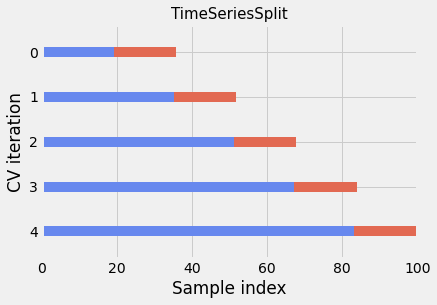

In [48]:
XX = np.arange(100)

n_split = 5

tscv = TimeSeriesSplit(n_splits=n_split)

plot_cv_indices(tscv, XX, n_splits=n_split)

In [50]:
class BlockingTimeSeriesSplit():
    
    def __init__(self, n_splits):
        self.n_splits = n_splits
    
    def get_n_splits(self, groups):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)
    
        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = int(0.8 * (stop - start)) + start
            yield indices[start: mid], indices[mid + margin: stop]

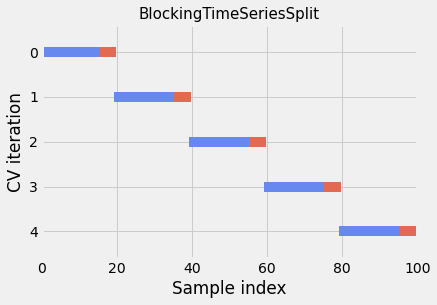

In [51]:
btscv = BlockingTimeSeriesSplit(n_splits=n_split)
plot_cv_indices(btscv, XX, n_splits=n_split)

In [1]:
btscv

NameError: name 'btscv' is not defined

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit

In [334]:
y = df_final.loc[:, 'VIX_Y']
X = df_final.loc[:,~(df_final.columns.isin(['VIX_Y','VIX_D_X','VIX_W_X','VIX_M_X']))]
# X = df_final.loc[:, df_final.columns != 'VIX_Y']

In [335]:
""" Train Test Split Random """

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)

In [436]:
""" Train Test Split for Time Series """

train_ind = int(len(df_final)*0.7)

X_train = X[:train_ind]
y_train = y[:train_ind]
X_test = X[train_ind:]
y_test = y[train_ind:]

In [437]:
X_train.head()

,dis,^GSPC,CL=F,^DJI,MSCI,oil,DXY,credit,term,FF,Mkt-RF,SMB,HML,RF,ST_Rev,tbill,eur,cny,gbp,jpy,GSPC_TR,DJI_TR,MSCI_TR,GSPC_TR_Change,DJI_TR_Change,MSCI_TR_Change,inf_M,SentMichigan,m1,house,indus,orders,crb,capa_level,capa_change
2010-02-04,0.47378,6.96895,4.29238,9.21056,3.26492,73.13000,94.14010,6.59000,3.53000,0.13321,-3.14000,-0.33000,-1.17000,0.00000,-0.62000,0.29000,-0.03244,0.00015,-0.02065,-0.00492,5.31485,2.75951,0.71836,0.26038,0.81908,-0.58001,-0.00081,-0.00965,0.01404,-0.00913,0.00391,-0.00179,-0.02557,71.07231,0.00593
2010-02-05,0.57929,6.97185,4.26535,9.21156,3.27155,71.15000,94.62180,6.81000,3.49000,0.13429,0.29000,-0.06000,0.01000,0.00000,0.68000,0.28000,-0.03458,-0.00004,-0.02017,0.00035,5.82318,2.78837,0.64618,0.05468,0.01025,0.32014,-0.00077,-0.00927,0.01376,-0.00670,0.00404,-0.00135,-0.01942,71.09571,0.00606
2010-02-12,0.43976,6.98055,4.30582,9.22021,3.28501,74.11000,93.99760,7.03000,3.59000,0.14179,-0.07000,0.97000,0.15000,0.00000,0.07000,0.34000,-0.00354,-0.00002,-0.00071,0.00045,3.71437,2.64704,0.71026,-0.04056,0.76670,-0.14991,-0.00045,-0.00656,0.01182,0.01031,0.00492,0.00178,-0.00667,71.25954,0.00697
2010-02-16,0.43817,6.99839,4.34394,9.23687,3.29896,76.98000,93.48200,7.02000,3.56000,0.14607,1.75000,-0.14000,1.01000,0.00000,0.76000,0.33000,0.02764,0.00000,0.00893,0.00113,3.57914,2.06025,0.21979,-0.02826,-0.25745,3.42835,-0.00026,-0.00502,0.01071,0.02003,0.00543,0.00356,0.02557,71.35315,0.00749
2010-02-17,0.38619,7.00262,4.34808,9.24080,3.28192,77.27000,93.71710,6.80000,3.64000,0.14714,0.49000,0.15000,0.12000,0.00000,0.22000,0.34000,-0.02736,0.00000,-0.00393,0.00081,3.71778,1.68701,0.54110,0.02981,-0.27651,-0.59463,-0.00022,-0.00463,0.01043,0.02246,0.00556,0.00401,-0.00338,71.37656,0.00762


In [438]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import MinMaxScaler


pipeline = Pipeline([
                     ('scaler', StandardScaler()),
                     ('model', Lasso())
])

In [453]:
search = GridSearchCV(pipeline,
                      {'model__alpha':np.arange(0.005,2,0.1)},
                      cv = 5, scoring="neg_mean_squared_error", verbose=0
                      )

In [454]:
search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', Lasso())]),
             param_grid={'model__alpha': array([0.005, 0.105, 0.205, 0.305, 0.405, 0.505, 0.605, 0.705, 0.805,
       0.905, 1.005, 1.105, 1.205, 1.305, 1.405, 1.505, 1.605, 1.705,
       1.805, 1.905])},
             scoring='neg_mean_squared_error')

In [455]:
search.best_params_

{'model__alpha': 0.005}

In [456]:
search.best_estimator_.named_steps['model'].coef_

array([-0.00331314, -0.        , -0.07615955, -0.08877026, -0.        ,
       -0.        ,  0.        ,  0.18884245,  0.04066532, -0.06775908,
       -0.03019413, -0.        ,  0.        ,  0.00901399,  0.00103198,
       -0.        ,  0.        , -0.        , -0.        , -0.        ,
        0.04617298,  0.02924818,  0.00305679, -0.        ,  0.        ,
        0.        , -0.        , -0.00598968,  0.00120426, -0.00534076,
       -0.        , -0.        ,  0.        ,  0.08503703,  0.        ])

In [457]:
coefficients = search.best_estimator_.named_steps['model'].coef_
importance = np.abs(coefficients)
importance

array([0.00331314, 0.        , 0.07615955, 0.08877026, 0.        ,
       0.        , 0.        , 0.18884245, 0.04066532, 0.06775908,
       0.03019413, 0.        , 0.        , 0.00901399, 0.00103198,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.04617298, 0.02924818, 0.00305679, 0.        , 0.        ,
       0.        , 0.        , 0.00598968, 0.00120426, 0.00534076,
       0.        , 0.        , 0.        , 0.08503703, 0.        ])

In [458]:
np.array(X_train.columns)[importance > 0]

array(['dis', 'CL=F', '^DJI', 'credit', 'term', 'FF', 'Mkt-RF', 'RF',
       'ST_Rev', 'GSPC_TR', 'DJI_TR', 'MSCI_TR', 'SentMichigan', 'm1',
       'house', 'capa_level'], dtype=object)

<Figure size 720x720 with 0 Axes>

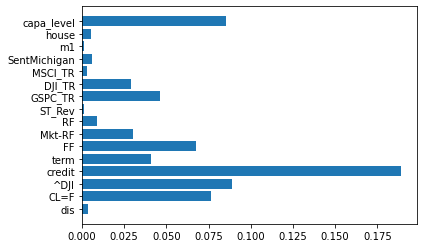

<Figure size 720x720 with 0 Axes>

In [459]:
from matplotlib import pyplot as plt

plt.barh(X_train.columns[importance > 0], importance[importance>0], align='center')
plt.figure(figsize=(10,10))

In [460]:
np.array(X_train.columns)

array(['dis', '^GSPC', 'CL=F', '^DJI', 'MSCI', 'oil', 'DXY', 'credit',
       'term', 'FF', 'Mkt-RF', 'SMB', 'HML', 'RF', 'ST_Rev', 'tbill',
       'eur', 'cny', 'gbp', 'jpy', 'GSPC_TR', 'DJI_TR', 'MSCI_TR',
       'GSPC_TR_Change', 'DJI_TR_Change', 'MSCI_TR_Change', 'inf_M',
       'SentMichigan', 'm1', 'house', 'indus', 'orders', 'crb',
       'capa_level', 'capa_change'], dtype=object)

In [50]:
""" Adaptive Lasso """

import asgl

In [51]:
lambda1 = (10.0 ** np.arange(-3, 1.51, 0.1))


tvt_alasso = asgl.TVT(model='lm', penalization='alasso', lambda1=lambda1, alpha=0, parallel=True,
                      weight_technique='lasso', error_type='MSE', random_state=42, intercept=False)

alasso_result = tvt_alasso.train_validate_test(x=np.array(X), y=np.array(y))


In [52]:
alasso_result

{'optimal_betas': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.]),
 'optimal_parameters': {'lambda1': 0.001,
  'alpha': None,
  'lasso_weights': array([10000., 10000., 10000., 10000., 10000., 10000., 10000., 10000.,
         10000., 10000., 10000., 10000., 10000., 10000., 10000., 10000.,
         10000., 10000., 10000., 10000., 10000., 10000., 10000., 10000.,
         10000., 10000., 10000., 10000., 10000., 10000., 10000., 10000.,
         10000., 10000., 10000.]),
  'gl_weights': None},
 'test_error': 0.0007415486467839318}

In [53]:
importance_alasso = np.abs(alasso_result['optimal_betas'])

X_train.columns[importance_alasso > 0]


Index([], dtype='object')

<BarContainer object of 0 artists>

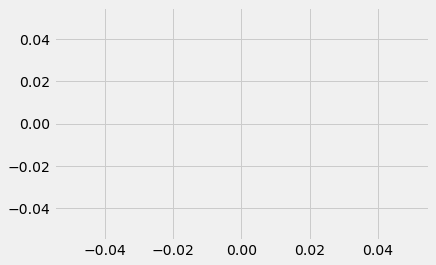

In [54]:
from matplotlib import pyplot as plt

plt.barh(X_train.columns[importance_alasso > 0], importance_alasso[importance_alasso>0])


# plt.barh(columns[sort_idx[0:30]],importance[sort_idx[0:30]])

In [1286]:
np.array(X_train.columns)[importance > 0]

array(['VIX_D_X', 'VIX_W_X', 'VIX_M_X', '^GSPC', 'credit', 'FF', 'jpy',
       'GSPC_TR', 'DJI_TR'], dtype=object)